# Búsqueda de Trabajo Secuencial Óptima

Mauricio M. Tejada

ILADES - Universidad Alberto Hurtado

Septiembre, 2017

---

## Modelo Básico

Buscamos resolver la siguiente ecuación de Bellman:
$$
R=b+\frac{\alpha }{r}\int_{R}^{\overline{w}}(1-F(w))dw
$$
Suponemos que $\log w \sim N(\mu,\sigma)$ y que $\overline{w}=\infty$

In [1]:
# Cargamos modulos necesarios
%matplotlib inline  
import scipy.stats as stats
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt

In [2]:
# Definición de Parámetros
b = 1
α = 0.30
r = 0.1
μ = 0.8
σ = 0.5
F = stats.lognorm(s = σ, loc = 0, scale = np.exp(μ))

In [3]:
# Función a integrar
integrando = lambda x: 1 - F.cdf(x)

In [4]:
# Iterarmos para encontrar el punto fijo
R0 = 1

diff = 10
tol  = 0.00001
step = 0.5

while diff > tol:
    R1   = b + (α/r)*integrate.quad(integrando, R0, np.inf)[0]
    diff = np.abs(R1-R0)
    R0   = R0 + step*(R1-R0)

print("El salario de reserva es: ", R1)    

El salario de reserva es:  2.509052205463034


Sabemos que $N(w) = w/r$ y que $U = R/r$. Usando estas funciones podemos repree gráficamente el equilibrio: 

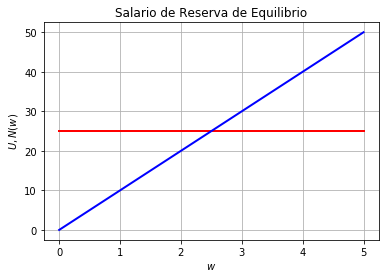

In [5]:
w  = np.linspace(0,5,10)
U  = (R1/r) * np.ones(len(w))
Nw = w/r

plt.plot(w, U, 'r-', linewidth=2)
plt.plot(w, Nw, 'b-', linewidth=2)
plt.xlabel(r'$w$')
plt.ylabel(r'$U,N(w)$')
plt.title('Salario de Reserva de Equilibrio')
plt.grid(True)
plt.show()

El código anterior funciona bien, pero si queremos probar diferentes valores de los parámetros lo óptimo es usar una función que al proveer los parámetros como insumo nos de como resultado el salario de reserva (y otros objetos de equilibrio). Definimos dicha función a continuación:

In [6]:
def SolveModel(parametrization, R0=1, tol=0.00001, step=0.5):
    b, α, r, F = parametrization
    diff = 10
    
    integrando = lambda x: 1 - F.cdf(x)
    
    while diff > tol:
        R1   = b + (α/r)*integrate.quad(integrando, R0, np.inf)[0]
        diff = np.abs(R1-R0)
        R0   = R0 + step*(R1-R0)
        
    h = α*(1-F.cdf(R1))
    
    return R1, h

Probemos ahora la función con la parametrización inicial:

In [7]:
parm = [b, α, r, F]    # Lista con la parametrización inicial

Req, heq = SolveModel(parm)
print("El salario de reserva es: ", Req)  
print("La Duración promedio del desempleo es: ", 1/heq) 

El salario de reserva es:  2.509052205463034
La Duración promedio del desempleo es:  8.22560425147


#### Efecto de un cambio de ingresos (desutilidad) de los desempleados

Ahora resolvamos el modelo para $b \in [0,2]$:

In [8]:
b_values  = np.linspace(0,2,10)
R_values_b = np.zeros(len(b_values))
h_values_b = np.zeros(len(b_values))

for i in range(len(b_values)):
    parmi = [b_values[i], α, r, F]
    R_values_b[i], h_values_b[i] = SolveModel(parmi)

Graficamos el efecto sobre el salarios de reserva:

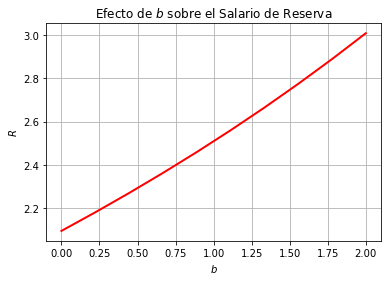

In [9]:
plt.plot(b_values, R_values_b, 'r-', linewidth=2)
plt.xlabel(r'$b$')
plt.ylabel(r'$R$')
plt.title('Efecto de '+r'$b$'+' sobre el Salario de Reserva')
plt.grid(True)
plt.show()

Graficamos el efecto sobre la probabilidad de salir del desempleo:

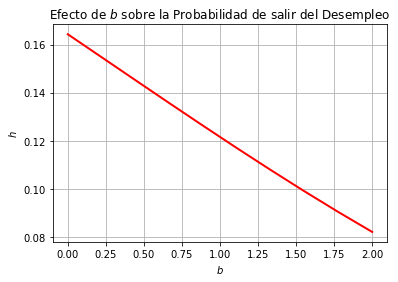

In [10]:
plt.plot(b_values, h_values_b, 'r-', linewidth=2)
plt.xlabel(r'$b$')
plt.ylabel(r'$h$')
plt.title('Efecto de '+r'$b$'+' sobre la Probabilidad de salir del Desempleo')
plt.grid(True)
plt.show()

#### Efecto de un cambio de la tasa a la cuál llegan las ofertas laborales

Ahora resolvamos el modelo para $\alpha \in [0,1]$:

In [11]:
α_values  = np.linspace(0,1,20)
R_values_α  = np.zeros(len(α_values))
h_values_α  = np.zeros(len(α_values))

for i in range(len(α_values)):
    parmi = [b, α_values[i], r, F]
    R_values_α[i], h_values_α[i] = SolveModel(parmi)

Graficamos el efecto sobre el salarios de reserva:

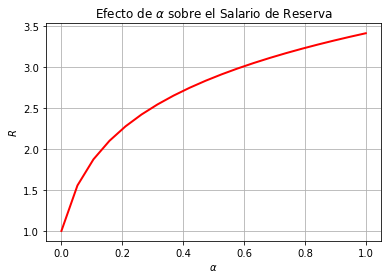

In [12]:
plt.plot(α_values, R_values_α, 'r-', linewidth=2)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$R$')
plt.title('Efecto de '+r'$\alpha$'+' sobre el Salario de Reserva')
plt.grid(True)
plt.show()

Graficamos el efecto sobre la probabilidad de salir del desempleo:

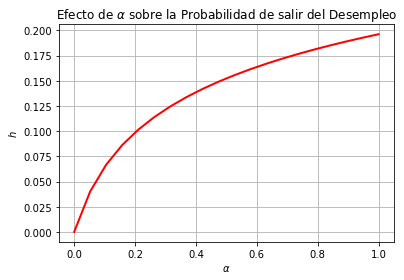

In [13]:
plt.plot(α_values, h_values_α, 'r-', linewidth=2)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$h$')
plt.title('Efecto de '+r'$\alpha$'+' sobre la Probabilidad de salir del Desempleo')
plt.grid(True)
plt.show()

#### Distribución de Salarios Aceptados

La distribución de salarios aceptados se deriva de la distribución de salarios $F(w)$. En particular, dicha distribución es $F(w)$ truncada a la izquierda al salario de reserva $R$.   La función de densidad es:
$$f_{A}(w) = f(w|w \geq R )= \frac{f(w)}{1-F(R)}$$
La función acumulada en tanto es:
$$F_{A}(w) = \int^{w}_{R} f(w|w \geq R ) = \frac{F(w)-F(R)}{1-F(R)}$$

In [14]:
# Función para obtener números aleatorios de una distribución truncada a la izquierda

def randTruncDist(Distribution, TruncPoint, Ndraws):
    """ Random numbers from a truncated distribuion
    
    Distribution: Distribution Object (stats.scipy)
    TruncPoint: Truncation point (left truncation)
    Ndraws: Number of draws
    
    """
    cdfTruncPoint = Distribution.cdf(TruncPoint)
    drawsU = cdfTruncPoint  + (1 - cdfTruncPoint)*np.random.rand(Ndraws)
    return Distribution.ppf(drawsU)

Comparemos ahora las distribuciones de salarios aceptados y ofrecidos generando 10000 números aleatorios de ambas distribuciones.

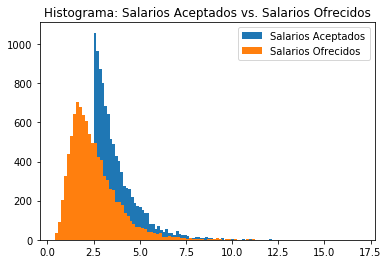

In [15]:
Ndraws = 10000
obswages = randTruncDist(F,R1,Ndraws)
wages    = F.rvs(Ndraws)

# Histograma
plt.hist(obswages, bins=100, label='Salarios Aceptados')
plt.hist(wages, bins=100, label='Salarios Ofrecidos')
plt.title('Histograma: Salarios Aceptados vs. Salarios Ofrecidos')
plt.legend()
plt.show()